In [ ]:
DBFILE = "allblocks-parity-poa-playground_run1.db"
NAME_PREFIX="parity-poa-playground_run1"  

# analyze `....db` data

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks-....db` database (created by `blocksDB_create.py`) containing all the blocks.

---

Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://github.com/drandreaskrueger/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


---

<a id='chainhammer1000'>20000 transactions shot at a node</a>
# my own experiment: 
## 20000 transactions submitted with `chainhammer` 


    


## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* [tables of peak TPS rates](#tables)
* [all 3 consecutive experiments](#allExperiments)
* [experiment 1](#experiment 1)
* [experiment 3](#experiment 3)


<a id='database'>Database</a>

In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

# my own routines:
from blocksDB_diagramming import DB_query, DB_tableSize, maxBlockNumber, check_whether_complete
from blocksDB_diagramming import add_blocktime, add_TPS, add_GUPS, add_GLPS

print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.0
numpy version 1.14.4
matplotlib version 2.2.2

Reading blocks table from allblocks-parity-poa-playground_run1.db


<a id='stats'>simple statistics</a>
### some simple statistics

In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?
minblock, maxblock = maxBlockNumber(conn)[0]

blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

# do we have consecutive blocks, none missing?
check_whether_complete(blocknumbers)

DB table names:  ('blocks',)
TABLE blocks has 222 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 221)] 
len(blocknumbers)= 222

complete between blocks 0 and 221.


In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 186736
txcount_max 1349
txcount_av 101.509009009009
txcount_sum 22535
blocks_nonempty_count 124
av tx per nonempty blocks =  181.73387096774192


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

### `geth` based clients have a nanosecond timestamp

not anymore?

In [ ]:
# transform nanoseconds to seconds
# df["timestamp"]=df["timestamp"]/1000000000
df[0:5]


,blocknumber,timestamp,size,gasUsed,gasLimit,txcount
0,0,0,535,0,6000000000,0
1,1,1534858197,578,0,6000000000,0
2,2,1534858199,578,0,6000000000,0
3,3,1534858204,578,0,6000000000,0
4,4,1534858320,578,0,6000000000,0


In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]
add_blocktime(df)


#df["TPS_1"]=df['txcount']/df['blocktime']
#df


# transactions per second
# with differently sized (rectangular) windows
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)


# gasUsed and gasLimit per second
add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
194,194,1534863726,186736,36006159,6000000000,1349,2.0,674.500000,215.000000,121.615385,68.535714,18003079.5,5.738565e+06,3.246036e+06,3.000000e+09,2.571429e+09,2.307692e+09
154,154,1534863606,108771,20925744,6000000000,784,2.0,392.000000,98.500000,65.916667,65.148148,10462872.0,2.629064e+06,1.759382e+06,3.000000e+09,2.250000e+09,2.500000e+09
200,200,1534863744,71925,13799247,6000000000,517,2.0,258.500000,65.888889,65.200000,95.250000,6899623.5,1.758640e+06,1.740253e+06,3.000000e+09,2.000000e+09,2.000000e+09
178,178,1534863681,173486,33443823,6000000000,1253,5.0,250.600000,130.272727,94.750000,71.687500,6688764.6,3.477109e+06,2.528972e+06,1.200000e+09,1.636364e+09,1.875000e+09
132,132,1534863543,150441,28986426,6000000000,1086,5.0,217.200000,90.076923,65.555556,64.515152,5797285.2,2.404243e+06,1.749743e+06,1.200000e+09,1.384615e+09,1.666667e+09
163,163,1534863636,147410,28399224,6000000000,1064,7.0,152.000000,95.076923,73.157895,85.843750,4057032.0,2.537698e+06,1.952657e+06,8.571429e+08,1.384615e+09,1.578947e+09
81,81,1534862049,93732,18016425,6000000000,675,5.0,135.000000,77.090909,24.914286,4.018433,3603285.0,2.057633e+06,6.682867e+05,1.200000e+09,1.636364e+09,8.571429e+08
126,126,1534863522,76478,14680050,6000000000,550,5.0,110.000000,64.555556,64.066667,64.233333,2936010.0,1.723052e+06,1.710003e+06,1.200000e+09,2.000000e+09,2.000000e+09
169,169,1534863654,72890,13986084,6000000000,524,5.0,104.800000,65.444444,64.933333,73.294118,2797216.8,1.746778e+06,1.733136e+06,1.200000e+09,2.000000e+09,2.000000e+09
209,209,1534863774,76339,14653359,6000000000,549,7.0,78.428571,64.250000,64.722222,76.593750,2093337.0,1.714897e+06,1.727501e+06,8.571429e+08,1.500000e+09,1.666667e+09


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
202,202,1534863750,27904,5284818,6000000000,198,3.0,66.000000,112.750000,65.200000,108.714286,1761606.0,3.009410e+06,1.740253e+06,2.000000e+09,2.250000e+09,2.000000e+09
203,203,1534863753,27629,5231436,6000000000,196,3.0,65.333333,64.555556,70.375000,106.379310,1743812.0,1.723052e+06,1.878379e+06,2.000000e+09,2.000000e+09,1.875000e+09
201,201,1534863747,26387,4991217,6000000000,187,3.0,62.333333,73.200000,65.400000,101.678571,1663739.0,1.953781e+06,1.745591e+06,2.000000e+09,1.800000e+09,2.000000e+09
200,200,1534863744,71925,13799247,6000000000,517,2.0,258.500000,65.888889,65.200000,95.250000,6899623.5,1.758640e+06,1.740253e+06,3.000000e+09,2.000000e+09,2.000000e+09
141,141,1534863570,25285,4777689,6000000000,179,3.0,59.666667,63.000000,63.000000,86.656250,1592563.0,1.681533e+06,1.681533e+06,2.000000e+09,2.000000e+09,2.000000e+09
163,163,1534863636,147410,28399224,6000000000,1064,7.0,152.000000,95.076923,73.157895,85.843750,4057032.0,2.537698e+06,1.952657e+06,8.571429e+08,1.384615e+09,1.578947e+09
186,186,1534863704,11762,2161971,6000000000,81,3.0,27.000000,36.250000,47.928571,85.741935,720657.0,9.675488e+05,1.279262e+06,2.000000e+09,2.250000e+09,2.142857e+09
185,185,1534863701,23076,4350633,6000000000,163,3.0,54.333333,50.125000,56.428571,83.677419,1450211.0,1.337886e+06,1.506135e+06,2.000000e+09,2.250000e+09,2.142857e+09
198,198,1534863737,7207,1281168,6000000000,48,2.0,24.000000,54.125000,150.692308,81.629630,640584.0,1.444650e+06,4.022128e+06,3.000000e+09,2.250000e+09,2.307692e+09
187,187,1534863707,998,80073,6000000000,3,3.0,1.000000,27.444444,34.642857,80.580645,26691.0,7.325197e+05,9.246525e+05,2.000000e+09,2.000000e+09,2.142857e+09


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

TODO - once this routine is also ready, move it out into `blocksDB_diagramming.py`   
but at the moment this is still in flux

In [ ]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True, bt_logy=True):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
    
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=6.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
    
    # TPS averages --> legend
    cols=['TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    averages=df[cols][blockFrom:blockTo].mean()
    legend = [col + " (av %.1f)" % averages[col] for col in cols]
    # print (legend)
    
    # TPS diagram
    cols = ['blocknumber'] + cols
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0])
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.legend(legend);
    
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1],
                                                               logy=bt_logy)
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
        
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
    
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    # save diagram to PNG file
    fig.savefig("img/%s_tps-bt-bs-gas_blks%d-%d.png" % (prefix,blockFrom,blockTo))


# <a id='allExperiments'>whole chain</a>


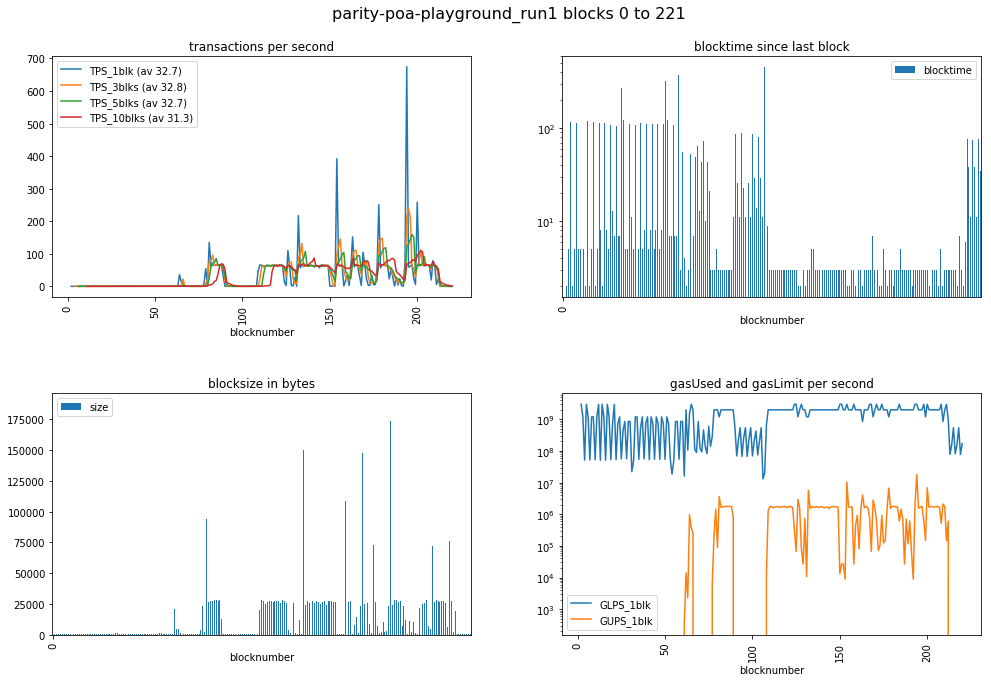

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX, gas_logy=True, bt_logy=True)

<a id='experiment1'>zoom in on one experiment</a>

# zooming in ...


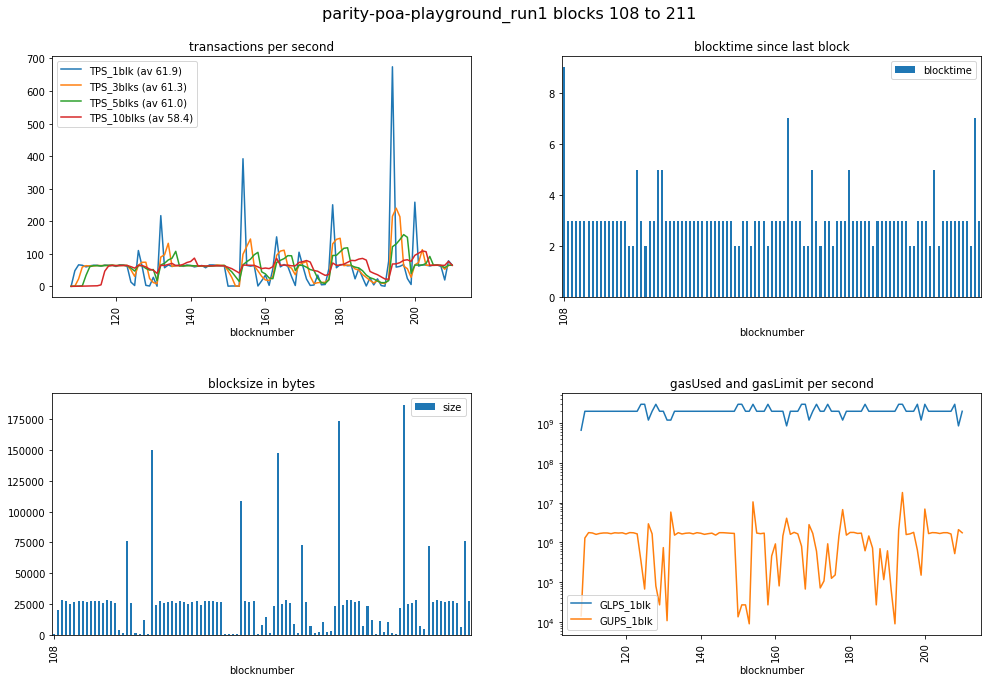

In [ ]:
# starting only at block xx because the waiting time before experiment start

diagrams(df, 108,211, NAME_PREFIX, gas_logy=True, bt_logy=False)